In [12]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import TwoLocal

from qvm.cut_library.util import cut_qubit_connections
from qvm.cut_library.decomposition import bisect

from qiskit_aer import AerSimulator
from qiskit.providers.ibmq import IBMQ
from qiskit.providers.fake_provider import FakeMumbaiV2, FakeOslo, FakeSherbrooke, FakeGuadalupeV2, FakeHanoiV2

In [13]:
# IBMQ.load_account()

# backend = provider.get_backend('ibm_hanoi')
backend = FakeOslo()

In [14]:
# num_qubits = 5
# reps = 1

# circuit = TwoLocal(
#     num_qubits=num_qubits,
#     rotation_blocks=["h"],
#     entanglement="circular",
#     entanglement_blocks="cx",
#     reps=reps,
# )
# circuit.measure_all()
# circuit = circuit.decompose()
# params = [(np.random.uniform(0.0, np.pi)) for _ in range(len(circuit.parameters))]
# circuit = circuit.bind_parameters(params)
# cp = circuit.copy()

from numpy import pi

n = 7
circuit = QuantumCircuit(n)
for i in range(n):
    # if i % 2 == 0:
    circuit.h(i)
    # circuit.rx(pi/2, i)
    # circuit.rz(pi/4, i)
# for i in range(2, n, 2):
#     circuit.rzz(pi/2, i-1, i)
for i in range(1, n, 2):
    circuit.cx(i-1, i)
for i in range(2, n, 2):
    circuit.cx(i-1, i)
# circuit.cx(0, n-1)
# for i in range(n):
#     circuit.rx(pi/2, i)
#     circuit.h(i)
# for i in range(1, n, 2):
#     circuit.cx(i-1, i)
# for i in range(2, n, 2):
#     circuit.cx(i-1, i)
    
circuit.cx(0, n-1)
circuit.measure_all()

initial_layout = [0, 1, 2, 3, 4, 5, 6]
# n = 2
# initial_layout = [7, 10, 12, 13, 14, 16, 19, 20]

# circuit = QuantumCircuit(n)
# circuit.h(0)
# circuit.cx([i for i in range(n-1)], [i for i in range(1, n)])
# circuit.measure_all()
# cp = circuit.copy()

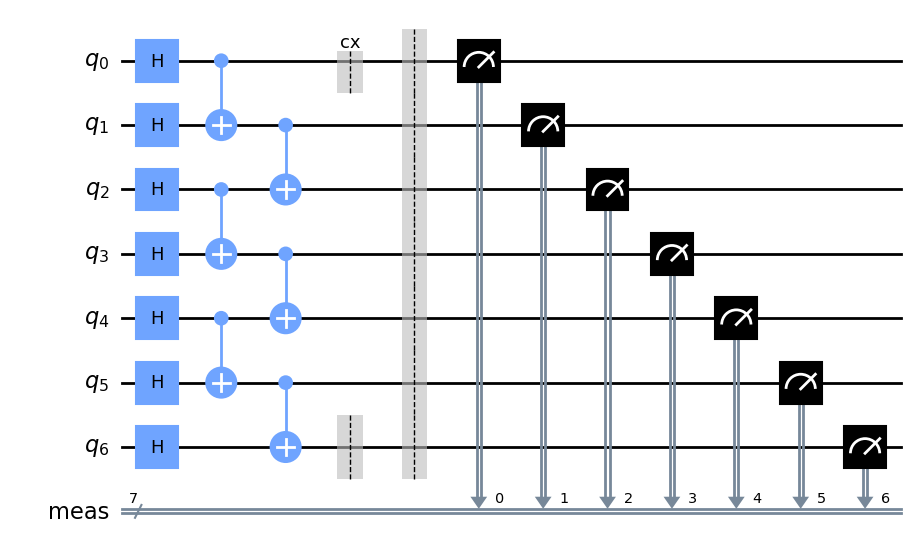

In [15]:
vc = cut_qubit_connections(circuit, [(circuit.qubits[0], circuit.qubits[-1])])
# vc = bisect(circuit)
# vc = circuit.copy()
vc.draw('mpl')

In [16]:



from qvm.virt_router import instantiate, knit
from qvm.quasi_distr import QuasiDistr
from qiskit.quantum_info import hellinger_fidelity
from IPython.display import display
from qiskit.compiler import transpile
from qvm.stack._virtualizer import Virtualizer
from qvm.virtual_gates import VirtualCZ
from qiskit.providers.fake_provider import FakeOslo



instances = instantiate(vc)
# display(instances[0].decompose().draw('mpl'))
instances = transpile(instances, backend, initial_layout=initial_layout, optimization_level=3)
t = transpile(circuit, backend, initial_layout=initial_layout, optimization_level=3)
# instances[0].draw('mpl')
job = backend.run([t]+instances, shots=20000)
t.draw('mpl')

In [ ]:


counts = job.result().get_counts()
counts = [counts] if isinstance(counts, dict) else counts
r3 = counts.pop(0)
distrs = [QuasiDistr.from_counts(count, 20000) for count in counts]
r1 = knit(vc, distrs)

r2 = AerSimulator().run(circuit, shots=20000).result().get_counts()
# display(cp.draw('mpl'))
print(hellinger_fidelity(r1.to_counts(20000), r2))

# r3 = backend.run(t, shots=20000).result().get_counts()
print(hellinger_fidelity(r3, r2))

0.9816678381401412
0.9761592062352454
